## Setup

In [1]:
import glob
import os
import subprocess
import pickle as cPickle
import ast
import matplotlib
from matplotlib import pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline
import pickle
## use `%matplotlib notebook` for interactive figures
# plt.style.use('ggplot')
import numpy as np
import sklearn
import tigramite
from tigramite import data_processing as pp
from tigramite import plotting as tp
from tigramite.pcmci import PCMCI
from tigramite.independence_tests.parcorr import ParCorr
import pandas as pd
import seaborn as sns


In [2]:
#path depending on timebin
pca_res_path="./c-transfer"
pcmci_res_path="./output"
f1_scores_path="./output_f1-scores/variables"
model_names=['ACCESS-CM2', 'BCC-CSM2-MR', 'CanESM5', 'CESM2', 'CNRM-CM6-1', 'EC-Earth3', 'HadGEM3-GC31-LL', 'IPSL-CM6A-LR', 'MIROC-ES2L',
             'MPI-ESM1-2-HR', 'UKESM1-0-LL']


In [3]:
related_models=[] 
related_models.append((0, 6, 10))

In [4]:
f1Scores={}
for file in os.listdir(f1_scores_path):
    f1_scores_single_path=os.path.join(f1_scores_path, file)
    f1_scores_single=pickle.load(open(f1_scores_single_path,"rb"))
    pc_alpha=f1_scores_single['pc_alpha']
    n_kept_comp=f1_scores_single['n_kept_comp']
    selected_comps=f1_scores_single['selected_comps']
    f1Scores[(pc_alpha, n_kept_comp, str(selected_comps))]=f1_scores_single['f1Scores']    

In [5]:
f1Scores_={} 
for key in f1Scores:
    scores=f1Scores[key]
    tempList={}
    for element in scores:
        for key2 in element:
            tempList[key2]=element[key2]
    sorted_dict = dict(sorted(tempList.items()))
    f1Scores_[key]=sorted_dict
    

In [6]:
avg_f1_scores_models={} #avg F1-Score for each refModel F1-Matrix
for key in f1Scores_:
    scores=f1Scores_[key]
    avg_f1_scores_models.setdefault(key, {})
    for key2 in scores:
        avg_f1_scores_models[key][key2]=np.nanmean(scores[key2], axis=(2, 3)) #also avg f1 score für key1=pc_alpha und key2=alpha_value

In [7]:
#metric1 for all refDatasets. Returns average f1-score-metric1-distance for all refDatasets
def metric1(f1scores): #f14d matrix
    result=[]
    for i,refDataset in enumerate(f1scores):
        scores=f1scores[i]
        min_scores=[]
        max_scores=[]
        for element in scores:
            arr=np.array(element)
            min_scores.append(np.nanmin(arr))
            max_scores.append(np.nanmax(arr))
        result.append(np.mean(np.subtract(max_scores, min_scores)))
    return result

In [8]:
def metric2_(key, f1scores, relModelsTuple, refModelIndex, alphaValue):#f1scores for specific model for testing! not full matrix
    avgF1Distance = np.full((len(relModelsTuple), len(model_names)), np.nan)
    for i, modelIndex in enumerate(relModelsTuple):
        for j, model in enumerate(model_names):
            if j not in relModelsTuple:
                val=abs(avg_f1_scores_models[key][alphaValue][refModelIndex][modelIndex]-avg_f1_scores_models[key][alphaValue][refModelIndex][j])
                avgF1Distance[i][j]=val
                                        
    return avgF1Distance, np.nanmean(avgF1Distance)
        
    
    

In [9]:
def plot_metric2_div_metric1(key):
    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0])
    plt.title(plotTitle)
    plt.ylabel('F1-Score')
    plt.figtext(0, 0, 'The resulting F1-Scores for N components, specific pc_alpha (see title) and different alpha_values vizualized')

    plt.ylim(0, 2)
    
    # Plot anzeigen
    plt.show()

In [10]:
metric1Mins={} #Mins for the metric1 mean values per (alphaValue, n_kept_comp)
for key in f1Scores_:
    metric1values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        metric1values.append(   (key2, np.mean((metric1(f1_score_single[key2]))))   )
    metric1Mins[key]=min(metric1values, key = lambda t: t[1])

        


In [11]:
metric2Maxs={}
for key in f1Scores_:
    metric2values=[]
    f1_score_single=f1Scores_[key]
    for key2 in f1_score_single:
        metric2values.append((key2, metric2_(key, None, related_models[0], 6, key2)[1]))
    metric2Maxs[key]=max(metric2values, key = lambda t: t[1])

In [12]:
metric2_div_metric1_maxs={}
metric2_div_metric1={}
for key in f1Scores_:
    metric2divmetric1values=[]
    f1_score_single=f1Scores_[key]
    metric2_div_metric1.setdefault(key, [])
    for key2 in f1_score_single:
        m1=np.mean(metric1(f1_score_single[key2]))
        m2=metric2_(key, None, related_models[0], 6, key2)[1]
        metric2divmetric1values.append((key2, m2/m1, m1, m2))
        metric2_div_metric1[key].append((key2, m2/m1))
    metric2_div_metric1_maxs[key]=max(metric2divmetric1values, key = lambda t: t[1])

In [13]:
metric2_div_metric1_maxs_2={} 
for key in metric2_div_metric1_maxs:
    pc_alpha=key[0]
    comps=key[1]
    deleted_var=key[2]
    alpha_value=metric2_div_metric1_maxs[key][0]
    metric2_div_metric1_maxs_2[(comps,pc_alpha,deleted_var,alpha_value)]=metric2_div_metric1_maxs[key][1]

In [14]:
sorted_dict_komps = dict(sorted(metric2_div_metric1_maxs_2.items(), key=lambda x: x[0][0])) #sortiert nach comps, dann pc_alpha

In [15]:
def scatter_plot_2(data,model_nr,title,name,save_name,vmin,vmax,nr_intervals,label, comps):
    size_s=40
    nr_models=len(data[:,0,0,0])
    average=0
    n_ensembles=nr_intervals
    all_values = []  

    for i in range(0,nr_models):
#         print i                                                                                                                                                                                                                                                           
#         if name[i]==name[model_nr]:                                                                                                                                                                                                                                       
#             print name[i]                                                                                                                                                                                                                                                 
        if name[i] in ['era', 'NCEP']: #2*datashape 3
            plt.scatter(np.ones((nr_intervals**2))*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='r',linewidth=2,s=size_s)
            else:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        else:
#             print name[i],data[model_nr,i,:,:].flatten()[0:n_ensembles]                                                                                                                                                                                                   
            plt.scatter(np.ones(4*4)*i,data[model_nr,i,:,:].flatten(),color='red',s=size_s)
#             print name[i],np.nanmean(data[model_nr,i,:,:],axis=(0,1))                                                                                                                                                                                                     
            if i==model_nr:
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='r',linewidth=2,s=size_s)
            else:
                average+=np.nanmean(data[model_nr,i,:,:],axis=(0,1))
                plt.scatter(i,np.nanmean(data[model_nr,i,:,:],axis=(0,1)),marker='x',color='k',linewidth=2,s=size_s)
        all_values.extend(data[model_nr, i, :, :].flatten())

    min_value = np.nanmin(all_values)
    max_value = np.nanmax(all_values)

    
    
    #### REVISE
    average/=(nr_models-1) #    average/=double(nr_models-1)
    print('average', average)
    plt.plot(np.linspace(-0.5,nr_models+1,100)-0.25,np.ones((100))*average,color='gray',linestyle='--',linewidth=2)
    plt.xticks(np.arange(0,nr_models),name[:],rotation=90,size=12)
    plt.ylabel(label,size=16,fontweight='bold')
    plt.xlim(-0.5,nr_models-0.5)
    #plt.ylim(vmin,vmax)
    plt.ylim(max(0, min_value-0.1), min(1, max_value+0.1))
    plt.title(title,fontweight='bold',size=12)
    plt.tight_layout()
    plt.savefig('./images/whichVariables/'+title+comps+'.pdf',dpi=600, bbox_inches='tight')
    plt.show()
    plt.close()

In [16]:
metric2_div_metric1=dict(sorted(metric2_div_metric1.items(), key=lambda x: x[0][1]))

In [17]:
temp={}
#pc_lpha, comps = zip((list(metric2_div_metric1_maxs.keys())))
temp2=list(metric2_div_metric1_maxs.keys())
pc_alpha, comps, deleted_var = zip(*temp2)
pc_alpha=list(set(pc_alpha))
comps=list(set(comps))
for key in comps:
    for key2 in deleted_var:
        temp.setdefault((key, key2), [])
    
#print(metric2_div_metric1_maxs.keys())
for key in metric2_div_metric1_maxs:
    temp[(key[1], key[2])].append((key[0], metric2_div_metric1_maxs[key][1]))
    
temp=dict(sorted(temp.items()))

In [18]:
import ast


def transformCompsToDecimal(listAsString):
    comps = ast.literal_eval(listAsString)
    value = 0
    for element in comps:
        value=value+2**element
    return value

def transformDecimalToComps(decimal_number):
    decimal_binary = bin(decimal_number)[2:] 

    binary_reversed = decimal_binary[::-1]

    original_list = list(range(100))  # Beispiel-Liste von 0 bis 99
    new_list = [original_list[i] for i, bit in enumerate(binary_reversed) if bit == '1']
    return new_list

In [19]:
metric2_div_metric1_maxs_2_compsCoded={}
for key in metric2_div_metric1_maxs_2:
    metric2_div_metric1_maxs_2_compsCoded[(key[0], key[1], key[3], transformCompsToDecimal(key[2]))]=metric2_div_metric1_maxs_2[key]
m2_div_m1_maxs_coded=metric2_div_metric1_maxs_2_compsCoded

# Visualizations

In [20]:
df1 = pd.DataFrame(columns=['|Components|', 'Components coded', 'pc_alpha', 'mci_alpha/alpha_value', 'score'])


# Erstellen eines leeren DataFrames mit den gewünschten Spaltennamen
df1 = pd.DataFrame(columns=['|Components|', 'Components coded', 'pc_alpha', 'mci_alpha/alpha_value', 'score'])

# Iterieren über das Dictionary und Erstellen einer Liste von Dicts
rows = [{'|Components|': key[0], 'Components coded': key[3], 'pc_alpha': key[1], 'mci_alpha/alpha_value': key[2], 'score': value} for key, value in m2_div_m1_maxs_coded.items()]

# Hinzufügen der erstellten Liste zum DataFrame df1
df1 = pd.concat([df1, pd.DataFrame(rows)], ignore_index=True)

# Anzeigen des erstellten DataFrames


df1 = df1.sort_values(by=['|Components|', 'score'], ascending=[True, True])
df1

,|Components|,Components coded,pc_alpha,mci_alpha/alpha_value,score
6,10,2015,0.15,7.000000e-05,0.625289
9,10,1791,0.15,5.000000e-08,0.668916
2,10,1023,0.15,1.000000e-09,0.750695
0,10,2046,0.15,7.000000e-07,0.785563
1,10,2045,0.15,3.000000e-05,0.816408
10,10,1535,0.15,1.000000e-04,0.816617
3,10,2043,0.15,3.000000e-05,0.842511
7,10,1983,0.15,7.000000e-05,0.858575
4,10,2039,0.15,7.000000e-06,0.895156
5,10,2031,0.15,3.000000e-05,0.902508


In [21]:
temp = metric2_div_metric1_maxs_2
result_dict = {}

for key, value in temp.items():
    if key[0] == 10:
        max_value = 10
    elif key[0] == 20:
        max_value = 20
    else:
        continue

    skipped_numbers = [num for num in range(0, max_value + 1) if num not in eval(key[2])]

    updated_key = (key[0], key[1], str(skipped_numbers), key[3])

    result_dict[updated_key] = value

pdDfData=[]
# Ausgabe des resultierenden Dictionaries
for key, value in result_dict.items():
    pdDfData.append((key[0], key[2], key[1], key[3], value))
columns = ['nr. components', 'missing components', 'pc_alpha', 'mci_alpha', 'M2/M1']

# Erstellen des DataFrames
df = pd.DataFrame(pdDfData, columns=columns)
df_sorted = df.sort_values(by=['nr. components', 'M2/M1'], ascending=[True, True])



In [22]:
df_sorted

,nr. components,missing components,pc_alpha,mci_alpha,M2/M1
6,10,[5],0.15,7.000000e-05,0.625289
9,10,[8],0.15,5.000000e-08,0.668916
2,10,[10],0.15,1.000000e-09,0.750695
0,10,[0],0.15,7.000000e-07,0.785563
1,10,[1],0.15,3.000000e-05,0.816408
10,10,[9],0.15,1.000000e-04,0.816617
3,10,[2],0.15,3.000000e-05,0.842511
7,10,[6],0.15,7.000000e-05,0.858575
4,10,[3],0.15,7.000000e-06,0.895156
5,10,[4],0.15,3.000000e-05,0.902508


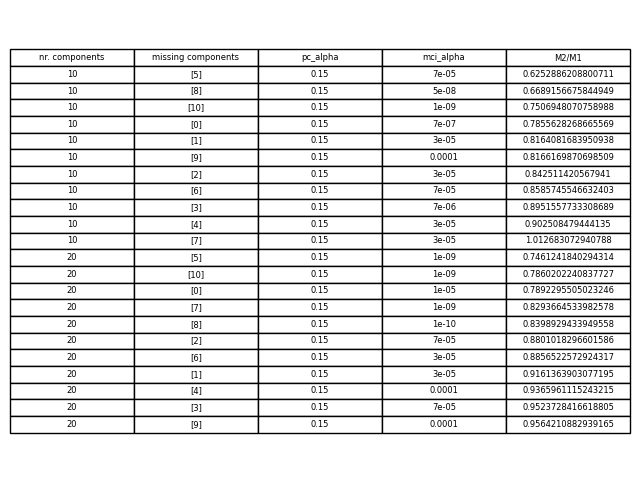

In [23]:
img_path = './images/whichVariables/missingVariables10-20_1.pdf'
fig, ax = plt.subplots(figsize=(8, 6))
ax.axis('tight')
ax.axis('off')
ax.table(cellText=df_sorted.values, colLabels=df.columns, cellLoc='center', loc='center')
#plt.savefig(img_path, bbox_inches='tight')

In [24]:
keys=list(metric2_div_metric1.keys())
pc_alpha_values, comps, deleted_var = zip(*keys)
comps=list(set(comps))
pc_alpha_values=list(set(pc_alpha_values))

subplots={}
for element in comps:
    for element2 in deleted_var:
        subplots.setdefault((element, element2), [])



def plot_metric2_div_metric1_(key):
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0]) + ', deleted_var: ' + str(key[2])
    if os.path.isfile('./images/whichVariables/'+plotTitle+'.png'):
        return

    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_uniform = np.linspace(min(x_values), max(x_values), len(x_values))
    labels=x_values

    # Plot erstellen
    plt.plot(x_uniform, y_values, marker='o', linestyle='-')

    # Labels hinzufügen
    for i, txt in enumerate(labels):
        plt.annotate(txt, (x_uniform[i], y_values[i]), textcoords="offset points", xytext=(0,10), ha='center')
        
    plt.title(plotTitle)
    plt.ylabel('M2/M1')
    plt.figtext(0, 0, 'The resulting F1-Scores for N components, specific pc_alpha (see title) and different alpha_values vizualized. The lables are the alpha_values for the resulting F1-Scores')

    plt.ylim(0, 2)

    plt.tight_layout()
  #  plt.savefig('./images/whichVariables/'+plotTitle+'.png',dpi=600)
    subplots[(key[1], key[2])].append('./images/whichVariables/'+plotTitle+'.png')
    plt.close()

    
    
for key in metric2_div_metric1.keys():
    plot_metric2_div_metric1_(key)
    
    
    


In [25]:
def plot_metric2_div_metric1__(key):
    plotTitle='Nr. of components: ' + str(key[1]) + ', pc_alpha: ' + str(key[0]) + ', deleted_var: ' + str(key[2])
   # if os.path.isfile('./images/whichVariables/'+plotTitle+'.png'):
    #    return

    # Gleichmäßig verteilte x-Werte erstellen
    values=metric2_div_metric1[key]
    x_values, y_values = zip(*values)
    x_values=list(x_values)
    y_values=list(y_values)
    x_values=np.log10(x_values)
    # Plot erstellen

        
    plt.title(plotTitle)
    plt.xlabel('log10(mci_alpha)')
    plt.ylabel('M2/M1')

    plt.ylim(0, 2)

    #plt.savefig('./images/whichVariables/'+plotTitle+'.png',dpi=600)
    plt.plot(x_values, y_values, marker='o', linestyle='-')
    plt.tight_layout()
  #  plt.savefig('./images/whichVariables/'+plotTitle+'.png',dpi=600, bbox_inches='tight')
    plt.show()
    print("test")


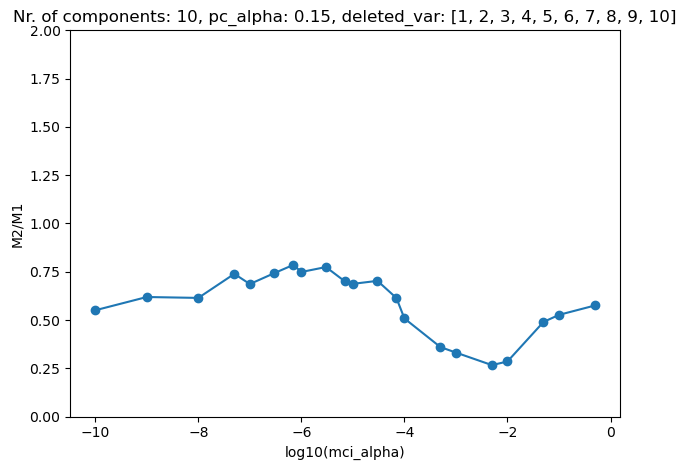

test


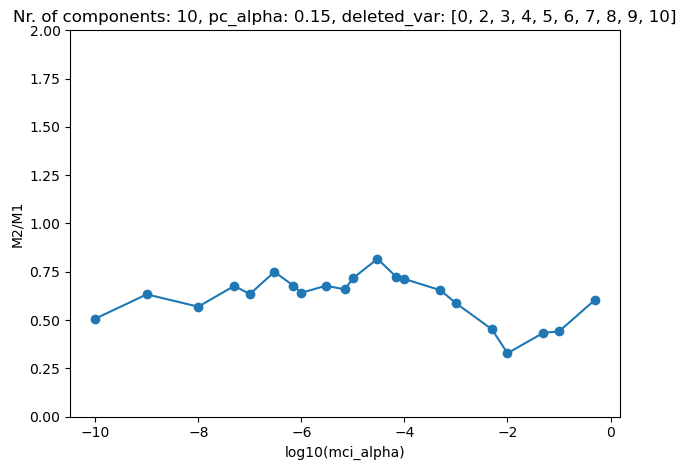

test


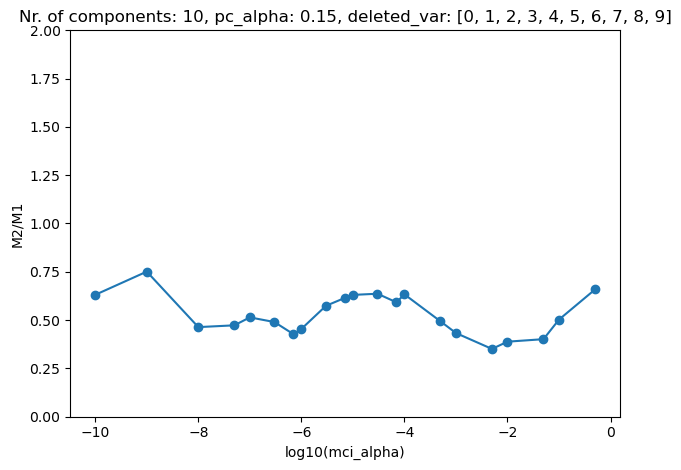

test


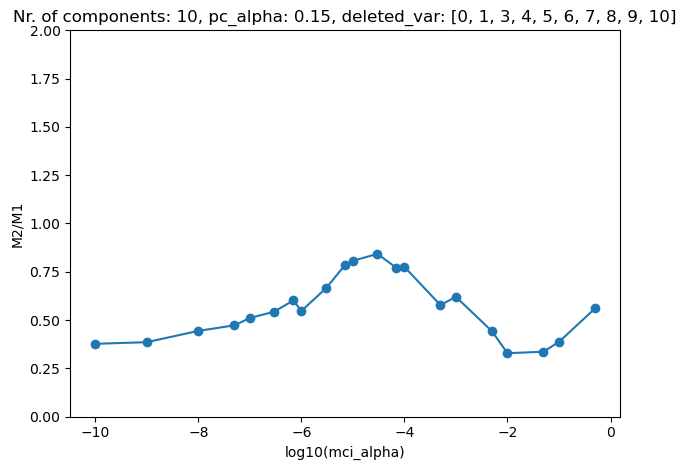

test


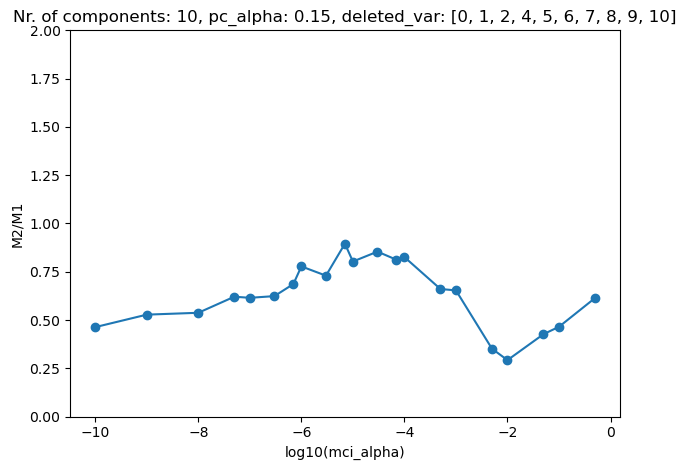

test


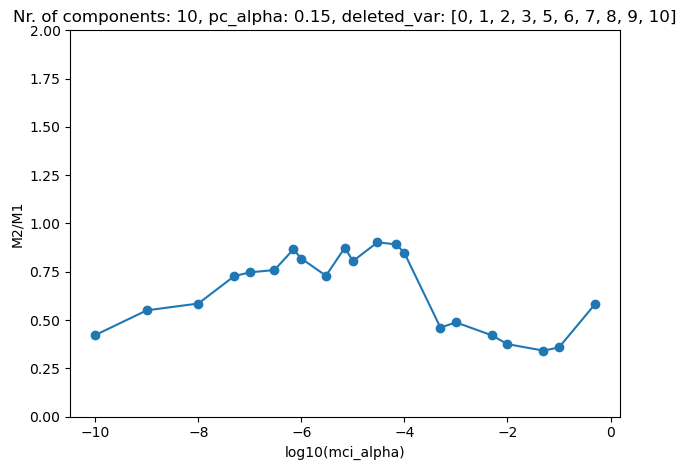

test


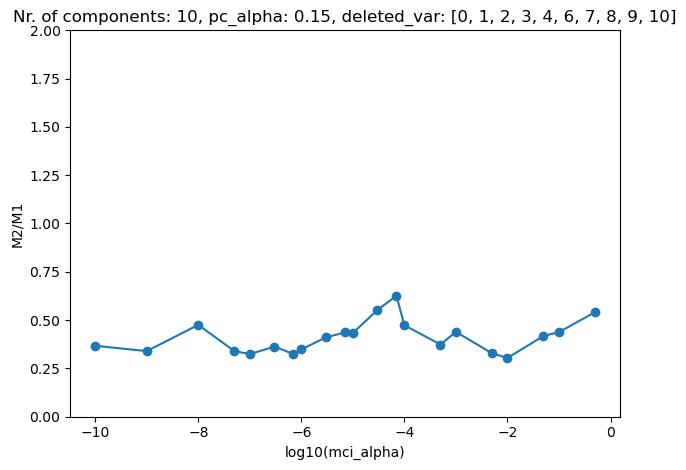

test


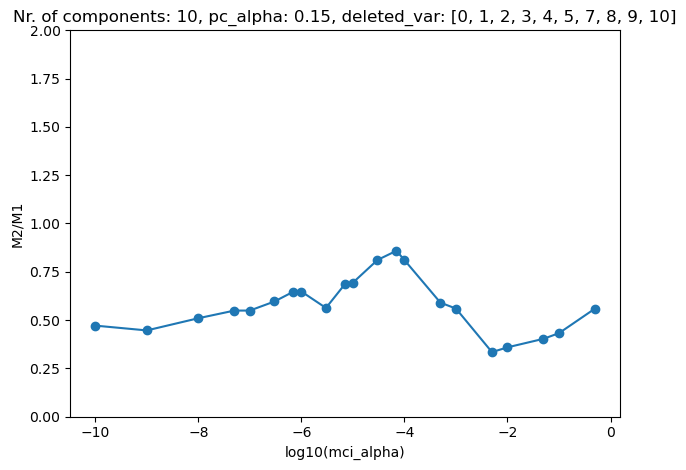

test


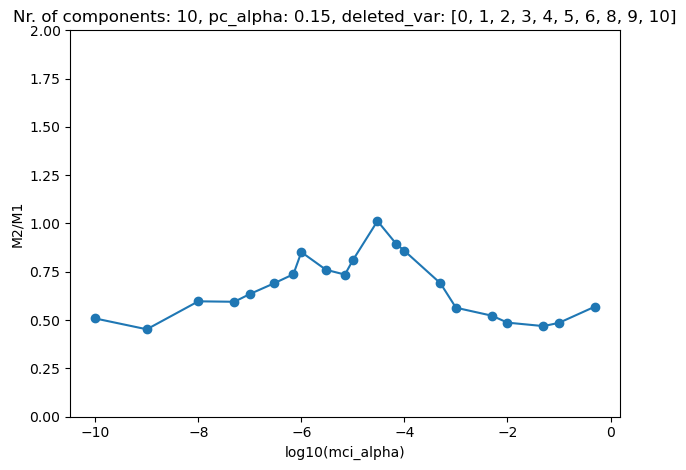

test


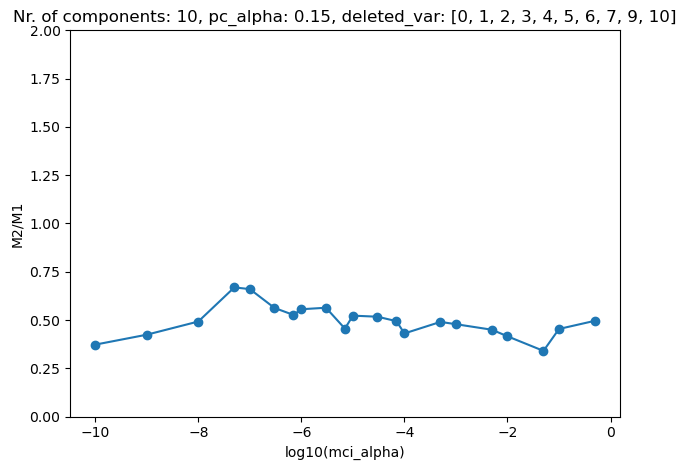

test


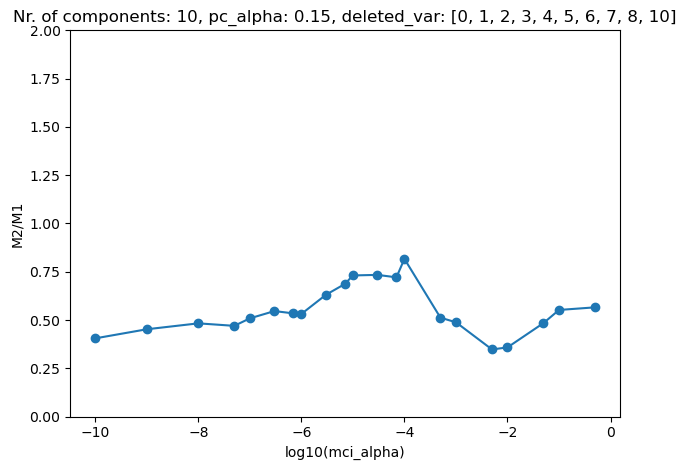

test


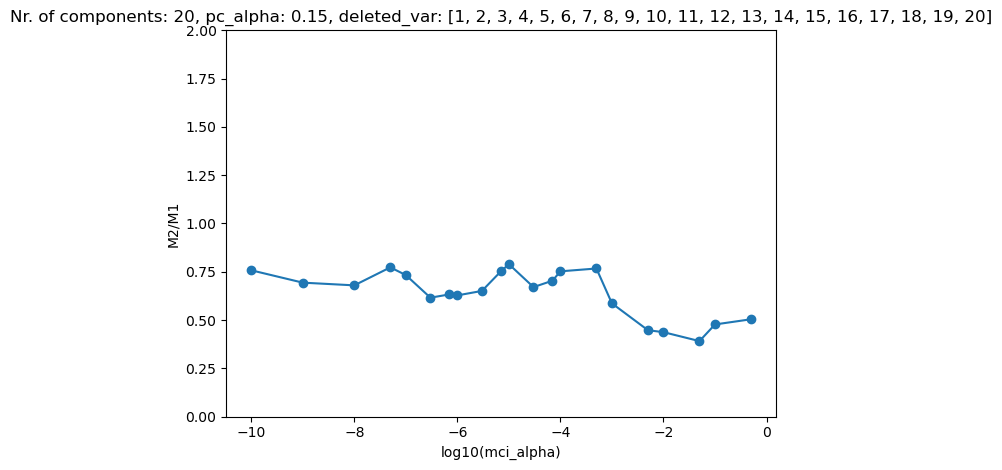

test


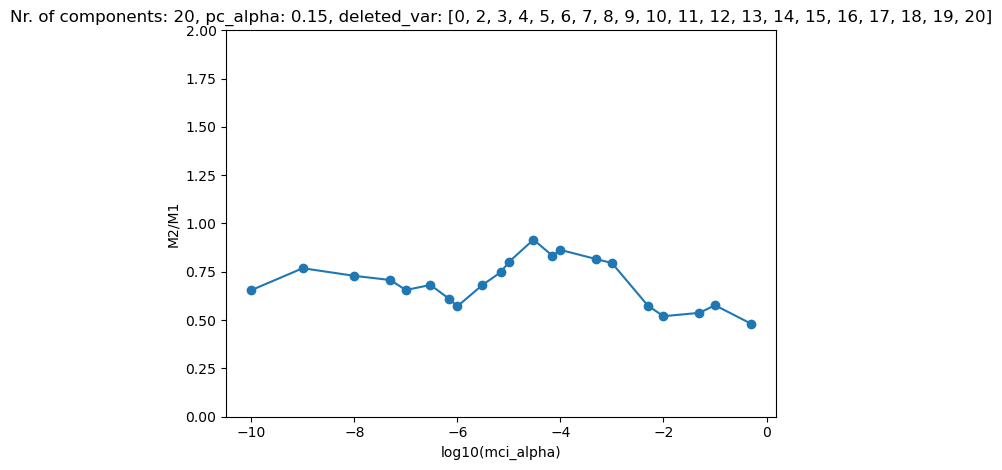

test


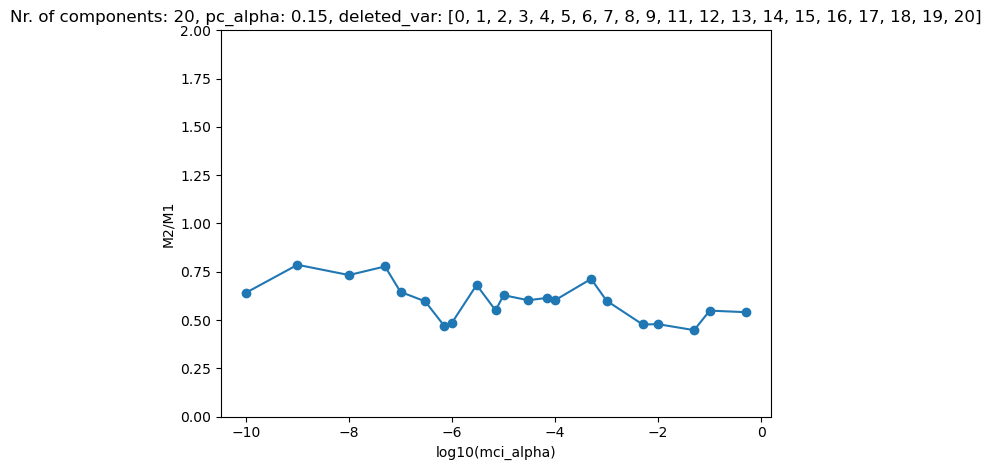

test


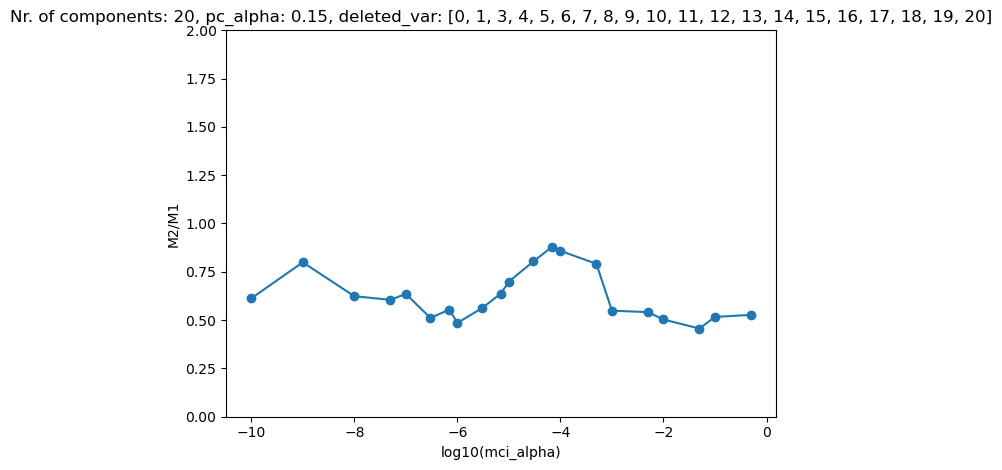

test


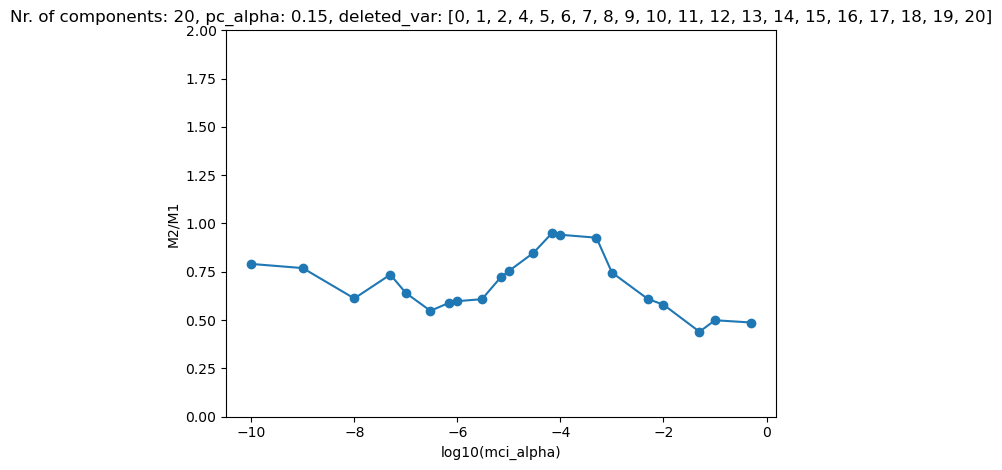

test


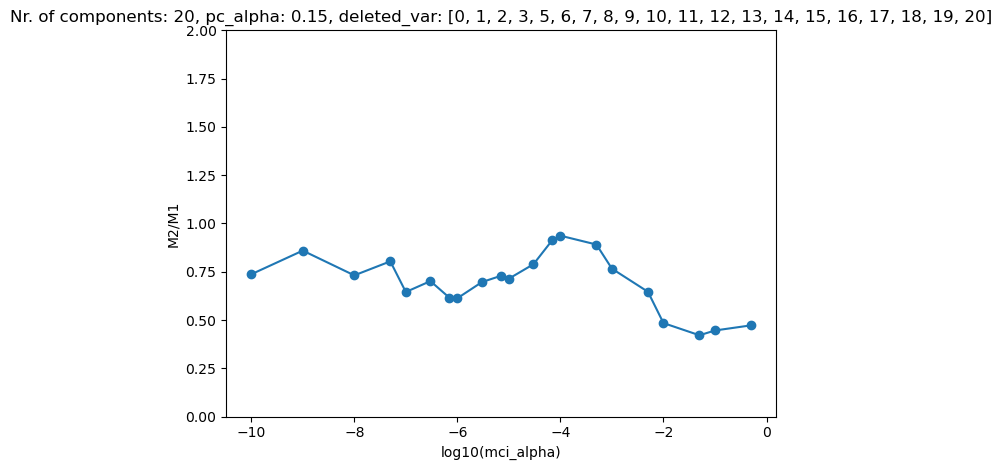

test


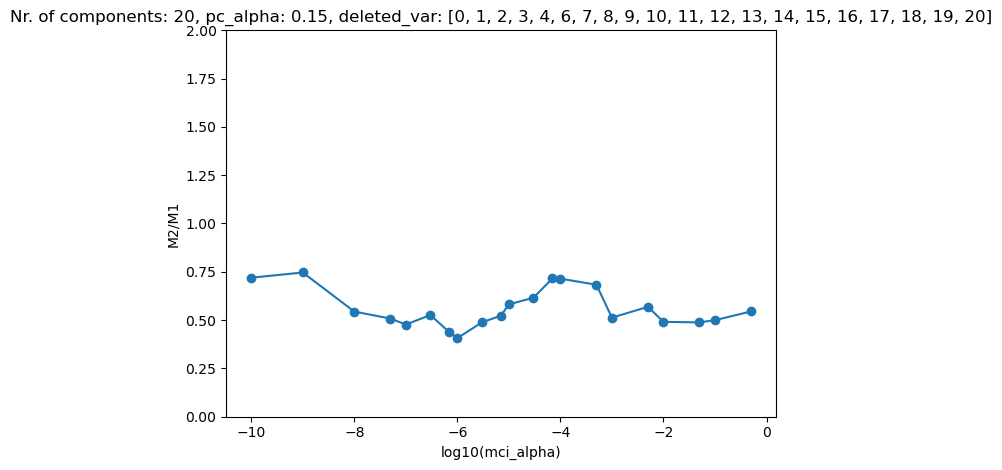

test


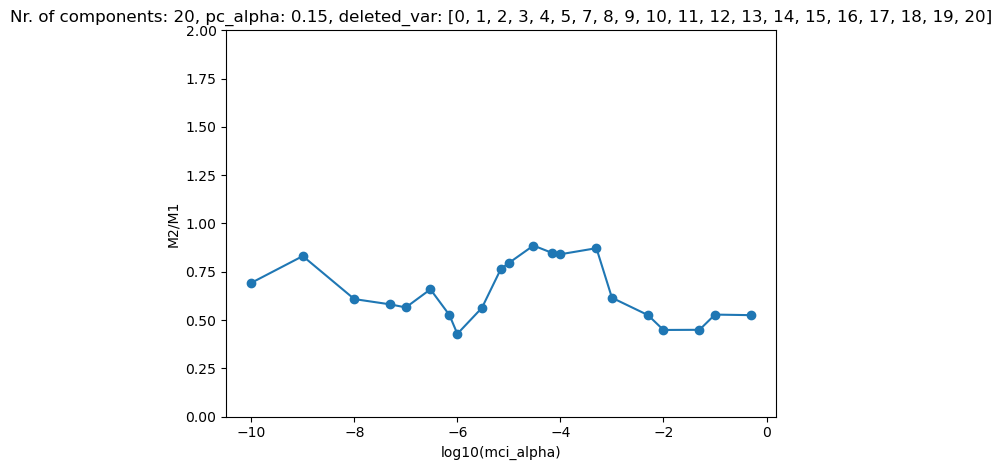

test


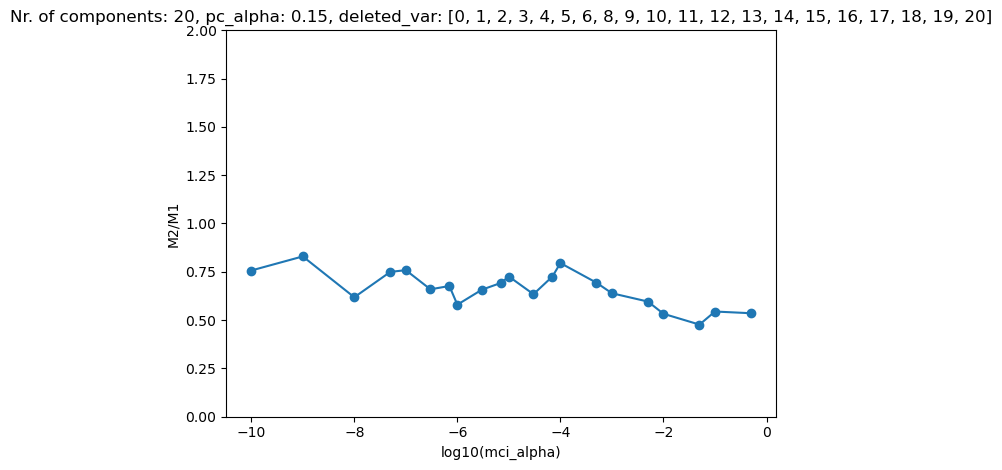

test


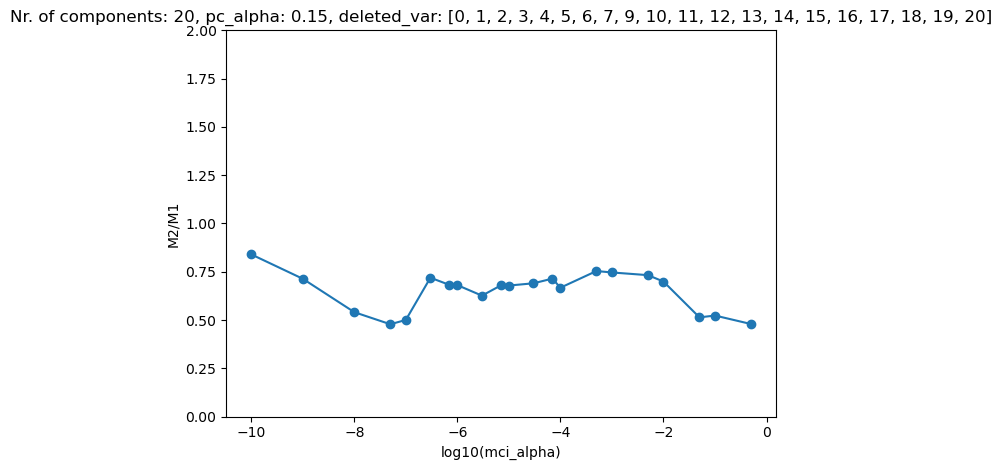

test


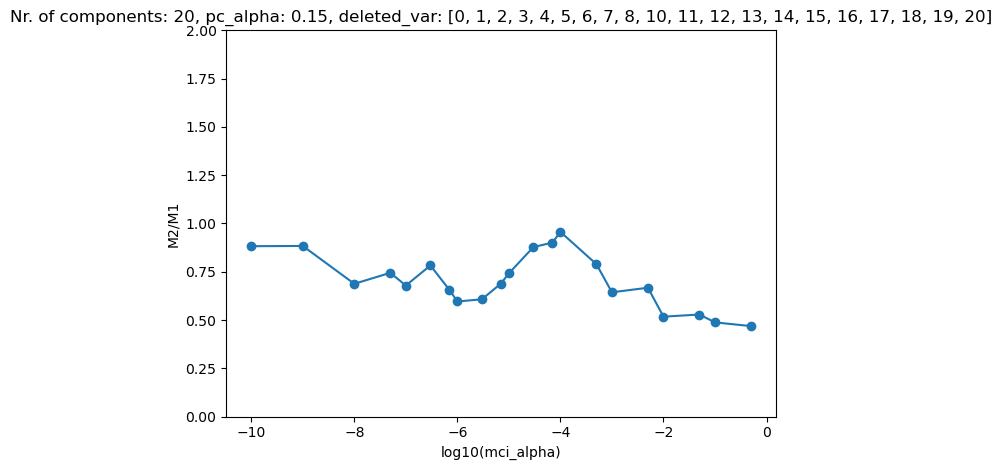

test


In [26]:
for key in metric2_div_metric1.keys():
    plot_metric2_div_metric1__(key)

average 0.8491220455445164


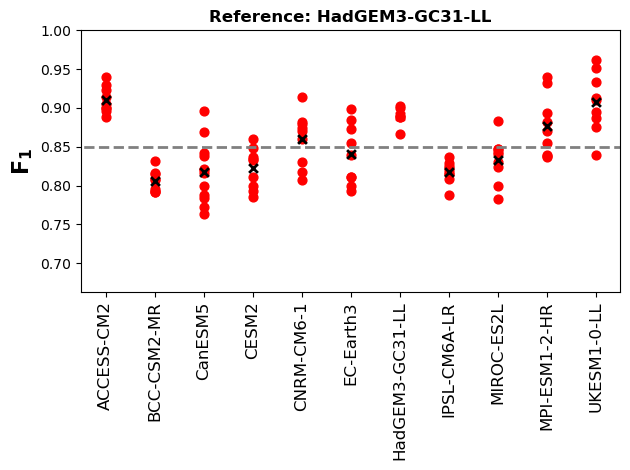

(10, 0.15, '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10]', 7e-07)
average 0.8039666858144846


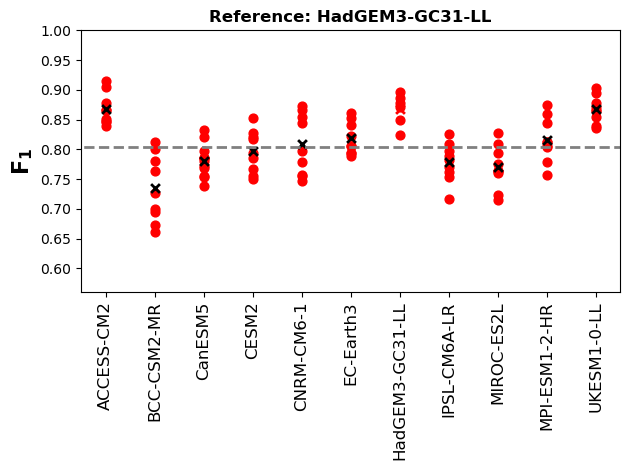

(10, 0.15, '[0, 2, 3, 4, 5, 6, 7, 8, 9, 10]', 3e-05)
average 0.8685638263955493


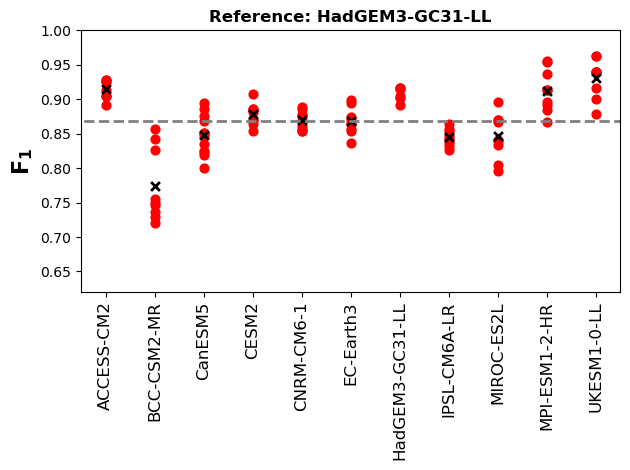

(10, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]', 1e-09)
average 0.821421687754011


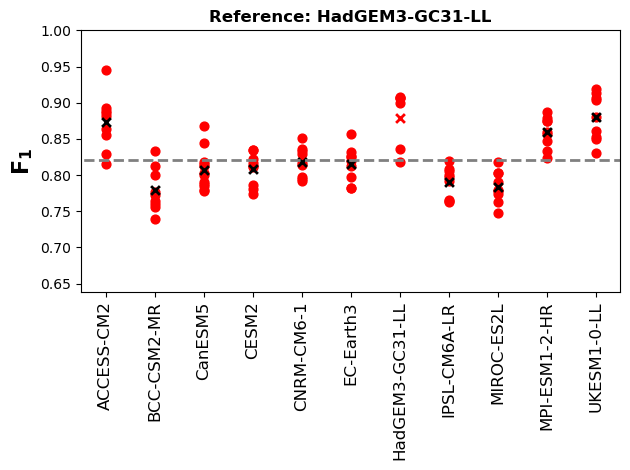

(10, 0.15, '[0, 1, 3, 4, 5, 6, 7, 8, 9, 10]', 3e-05)
average 0.821502834946753


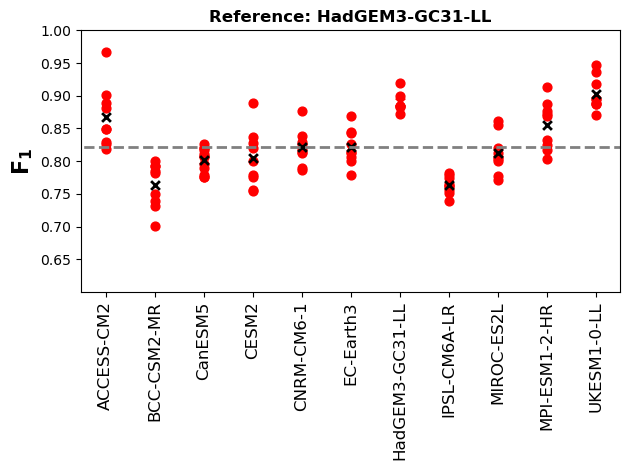

(10, 0.15, '[0, 1, 2, 4, 5, 6, 7, 8, 9, 10]', 7e-06)
average 0.7874480609638381


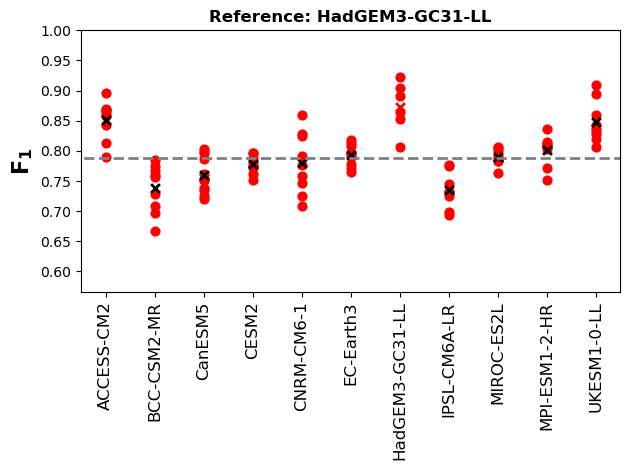

(10, 0.15, '[0, 1, 2, 3, 5, 6, 7, 8, 9, 10]', 3e-05)
average 0.807337620594401


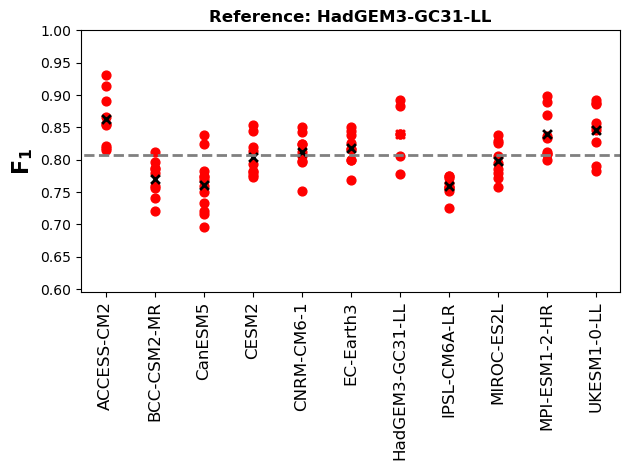

(10, 0.15, '[0, 1, 2, 3, 4, 6, 7, 8, 9, 10]', 7e-05)
average 0.7858307750352027


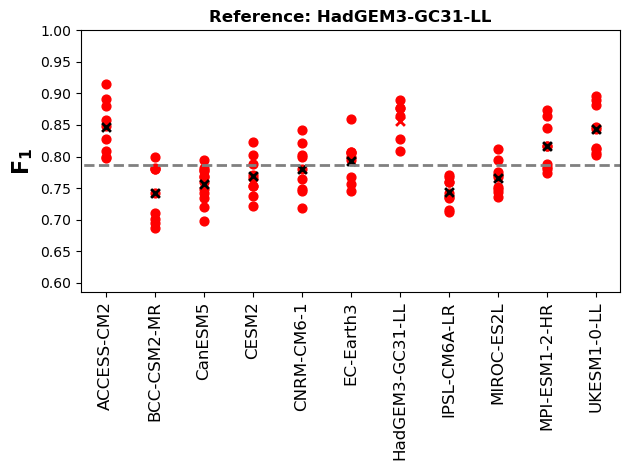

(10, 0.15, '[0, 1, 2, 3, 4, 5, 7, 8, 9, 10]', 7e-05)
average 0.8015043981937398


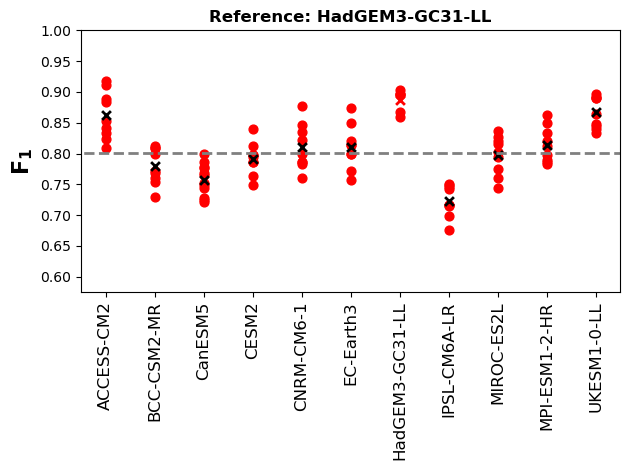

(10, 0.15, '[0, 1, 2, 3, 4, 5, 6, 8, 9, 10]', 3e-05)
average 0.8414374647290879


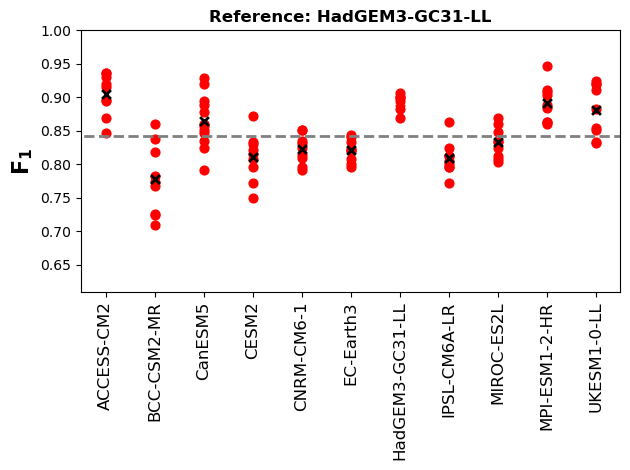

(10, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10]', 5e-08)
average 0.7938972700221207


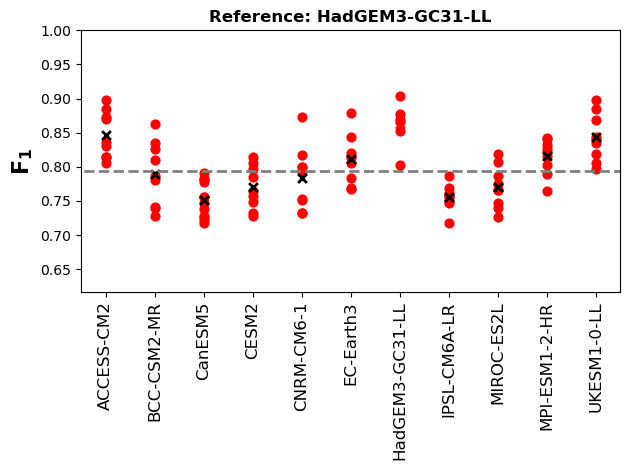

(10, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 8, 10]', 0.0001)
average 0.8000030776310337


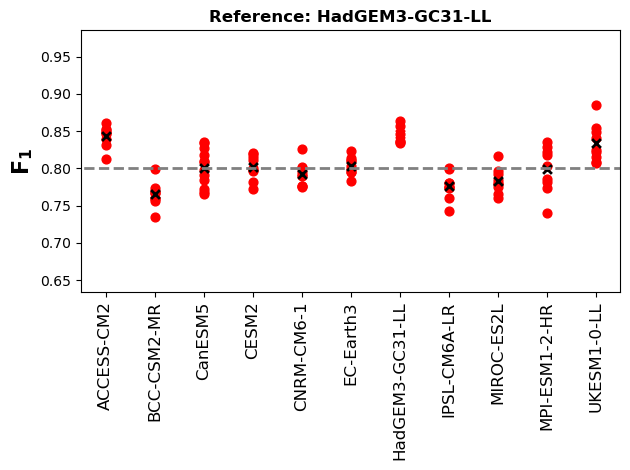

(20, 0.15, '[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 1e-05)
average 0.7870232824782801


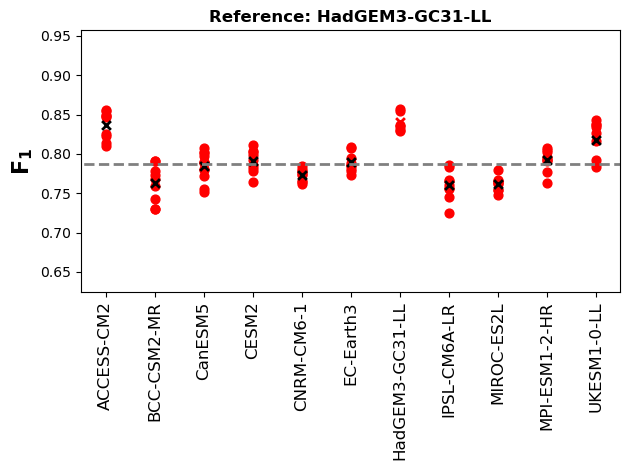

(20, 0.15, '[0, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 3e-05)
average 0.8622823460177704


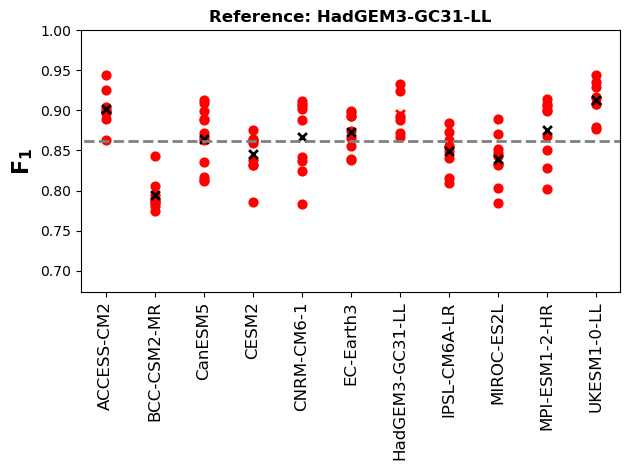

(20, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 1e-09)
average 0.7836079842045608


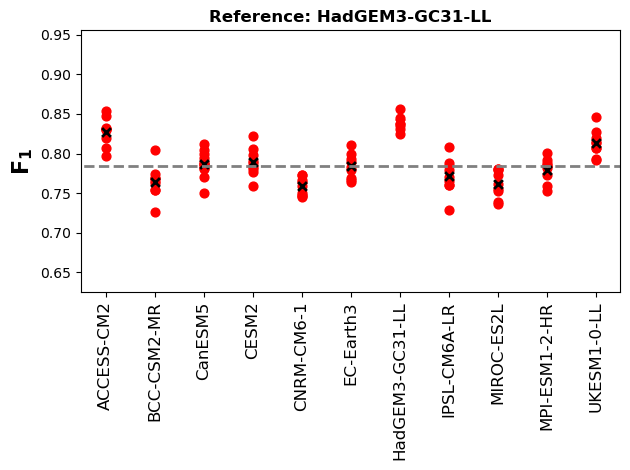

(20, 0.15, '[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 7e-05)
average 0.7807938254213356


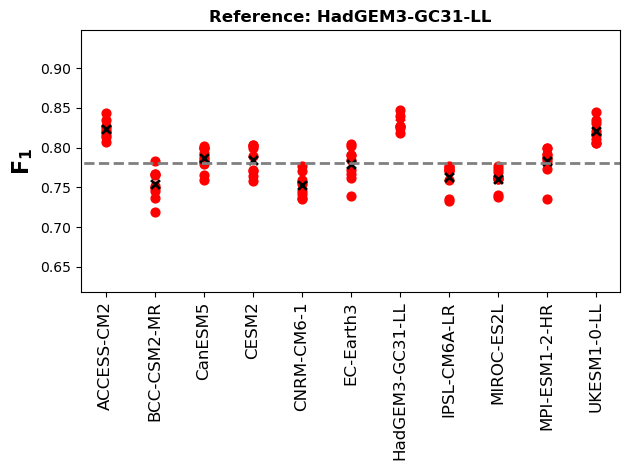

(20, 0.15, '[0, 1, 2, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 7e-05)
average 0.7733403745368713


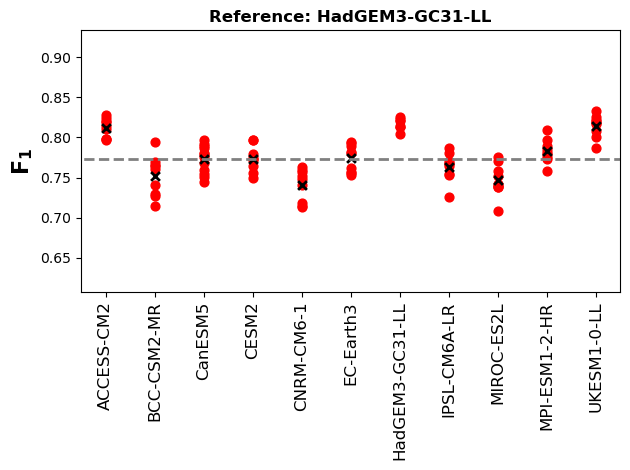

(20, 0.15, '[0, 1, 2, 3, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 0.0001)
average 0.8516908690046492


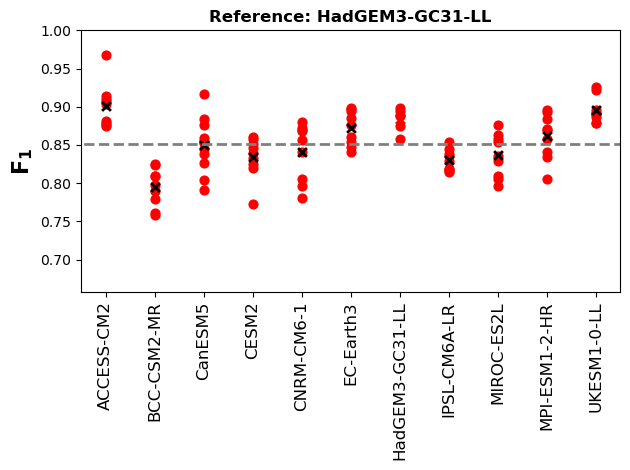

(20, 0.15, '[0, 1, 2, 3, 4, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 1e-09)
average 0.7890913808974878


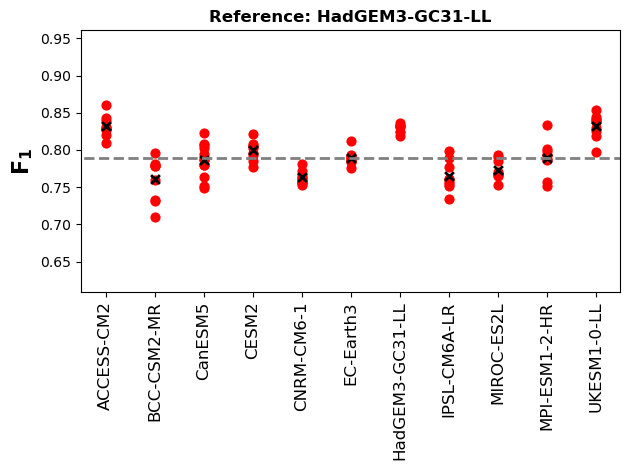

(20, 0.15, '[0, 1, 2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 3e-05)
average 0.8500891786080927


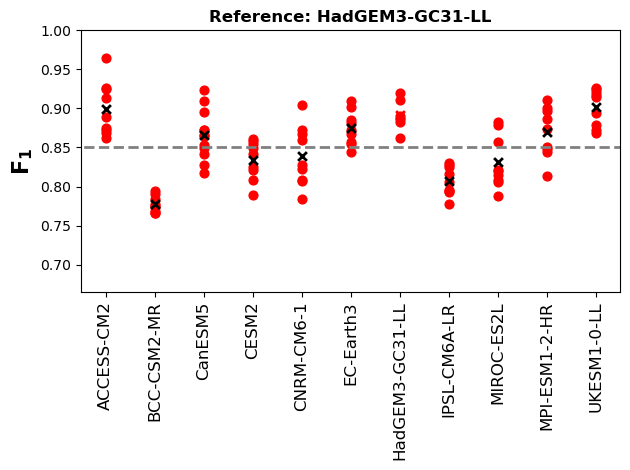

(20, 0.15, '[0, 1, 2, 3, 4, 5, 6, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 1e-09)
average 0.849451316706543


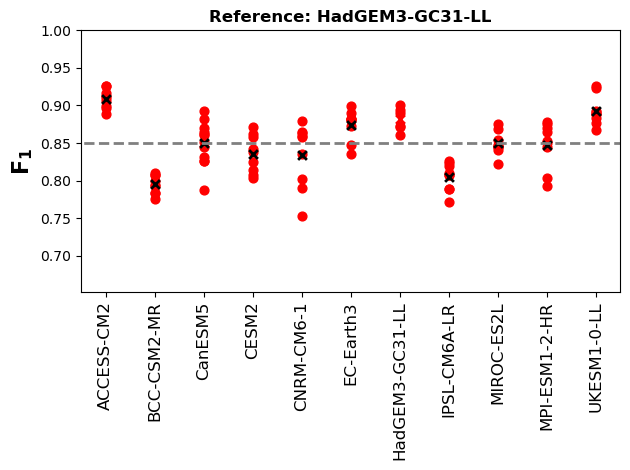

(20, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 1e-10)
average 0.7753653185604041


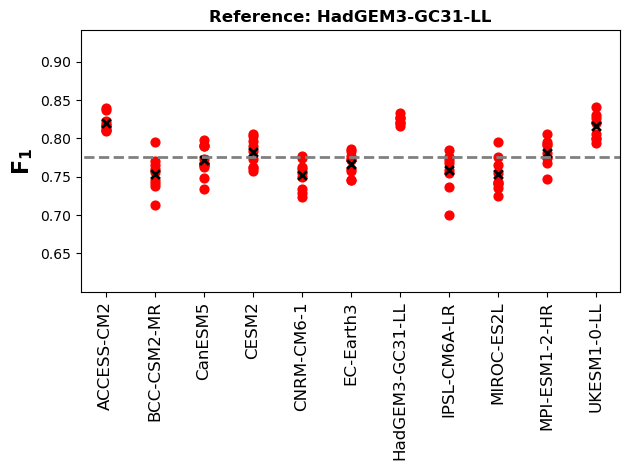

(20, 0.15, '[0, 1, 2, 3, 4, 5, 6, 7, 8, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]', 0.0001)


In [27]:
for key in sorted_dict_komps:
    scatter_plot_2(f1Scores_[(key[1],key[0],key[2])][key[3]], 6, 'Reference: ' + model_names[6], model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$', key[2])
    print(key)
    #scatter_plot_2(f1Scores_[(key[1],key[0],key[2])][key[3]], 6, "comps: " + str(key[0]) + "|pc_alpha: " + str (key[1]) + "|deleted_var: " + str(key[2]) + "|alpha_value: " + str(key[3]), model_names, 'scatterplot2', 0.5, 1, 3, r'F$_{\mathbf{1}}$')